In [82]:
import sys, os
sys.path
from os.path import join, abspath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import json
import random
import yaml
from addict import Dict
import ast
from utils import ExpandStrArrayColumns, MovingAvg

In [113]:
def Dashboard(train_report: pd.DataFrame, eval_report: pd.DataFrame, window_size: int=100):
    loss_ma = MovingAvg(train_report.loss, window_size)
    dice_ma = MovingAvg(train_report.dice_scores, window_size)
    sel_cols = ["learning_rate", "dice_scores"]
    train_epoch_stats = train_report.groupby("epoch").mean(numeric_only=True)[sel_cols]
    eval_epoch_stats = eval_report.groupby("epoch").mean(numeric_only=True)
    lim = len(eval_epoch_stats.index)
    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle("Training Log")
    # plot loss
    axs[0, 0].set_title("Loss")
    axs[0, 0].set_xlabel("Block")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].scatter(train_report.index, train_report.loss, s=0.3, c="red", label="value")
    axs[0, 0].plot(train_report.index, loss_ma, "-b", label="moving avg")
    axs[0, 0].legend()
    # plot block stats
    axs[0, 1].set_title("Block Statistics")
    axs[0, 1].set_xlabel("Block")
    axs[0, 1].set_ylabel("Score")
    # axs[0, 1].set_ylim([-0.05, 1.05])
    axs[0, 1].scatter(train_report.index, train_report.dice_scores, s=0.5, c="red", label="dice_score")
    axs[0, 1].plot(train_report.index, dice_ma, "-c")
    axs[0, 1].legend()
    # plot learning rate
    axs[1, 0].set_title("Learning Rate")
    axs[1, 0].set_xlabel("Block")
    axs[1, 0].set_ylabel("Learning Rate")
    axs[1, 0].plot(train_report.index, train_report.learning_rate, "-r", linewidth=1.)
    # plot epoch stats
    axs[1, 1].set_title("Dice Scores")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Score")
    # axs[1, 1].set_ylim([-0.05, 1.05])
    axs[1, 1].plot(eval_epoch_stats.index, eval_epoch_stats.dice_scores, "-r",
                   linewidth=1.5, label="eval_dice")
    axs[1, 1].plot(eval_epoch_stats.index, train_epoch_stats.dice_scores[:lim], "--r",
                   linewidth=1.5, label="train_dice")
    axs[1, 1].legend()
    plt.tight_layout()
    plt.show() 

In [117]:
train_rep_dir = "/home/isaiah/TotalSegmentator/results/20230324/nnunet_train_reps_01/"
eval_rep_dir = "/home/isaiah/TotalSegmentator/results/20230324/nnunet_eval_reps_01/"

tdfs = []
edfs = []
for i in range(5):
    tfile = join(train_rep_dir, f"rank{i}.csv")
    efile = join(eval_rep_dir, f"rank{i}.csv")
    tdfs.append(pd.read_csv(tfile))
    edfs.append(pd.read_csv(efile))
tdf = pd.concat(tdfs, axis=0)
edf = pd.concat(edfs, axis=0)
dfg_train = tdf.groupby("block").mean().astype({"epoch": np.uint8})
efg_train = ExpandStrArrayColumns(edf, "epoch")

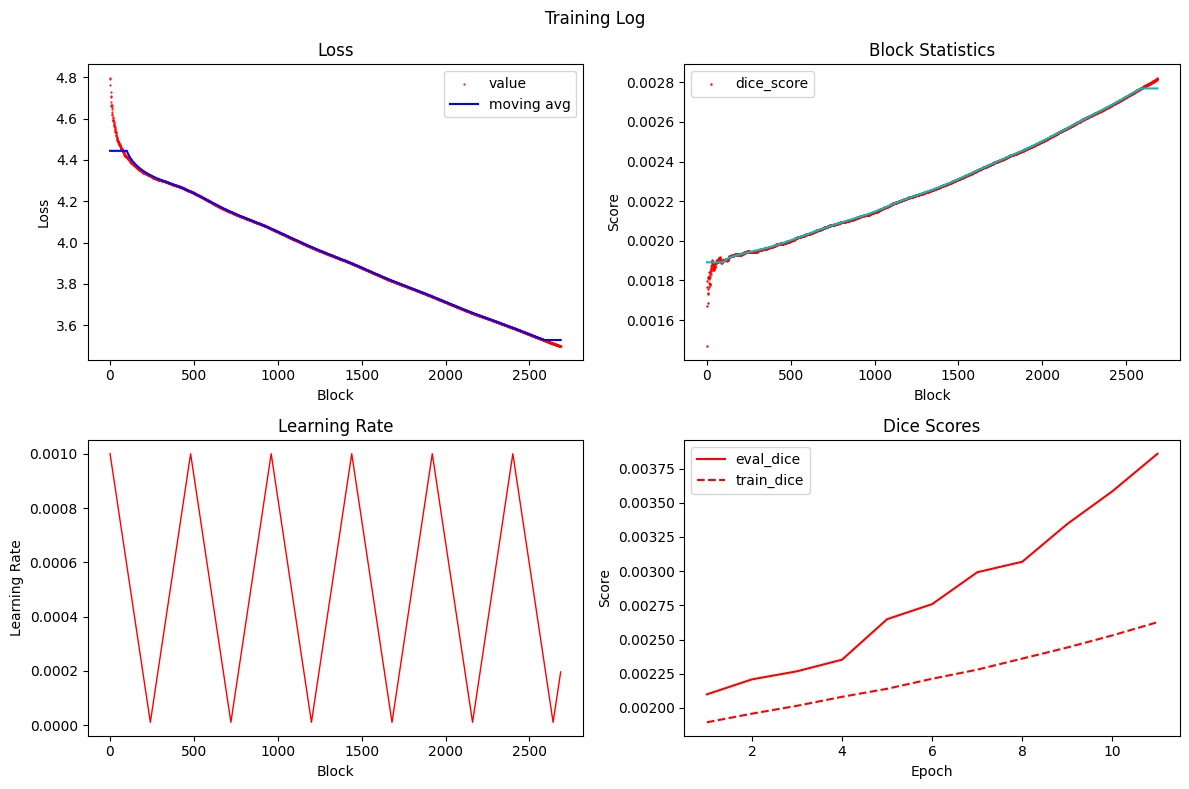

In [118]:
Dashboard(dfg_train, efg_train, window_size=100)